# スコアとランキング
## Agenda

- スコアリング関数の開発
- アローの不可能性定理
- Z scoreと正規化

## 参考

- [Github](https://github.com/yeseullee/Data-science-design-manual-notebooks/blob/master/Chapter4.ipynb)
- [BMI Data](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=examination)

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Import

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

## 1. BMI

$$
\text{BMI} = \frac{\text{体重 kg}}{\text{身長 m}^2}
$$

- BMIは、体重がコントロールできているかわかるスコア（統計量）
- 表面積は身長の二乗に比例することを根拠としている（体重は体積に比例するので三乗の方が理論的には良いが経験的にBMIの方がfitが良いとされている）
- BMIは体脂肪率の代用尺度

### BMIの目安

- 低体重：BMI < 18.5
- 標準体重: $18.5 \leq \text{BMI} < 25$
- 軽度肥満：$25 \leq \text{BMI} < 30$
- 肥満：$30 \leq \text{BMI}$

### アメリカ人のBMI plot

In [37]:
### Dataの読み込み sas datafile
df = pd.read_sas('./data/BMX_H.XPT')
df['ht_m']=(df['BMXHT'])*0.01

In [38]:
### make labels
df['label'] = pd.cut(df.BMXBMI,
                     [-np.inf, 18.5, 25.0 , 30.0,np.inf],
                     labels=['underweight','normal', 'overweight','obese'])

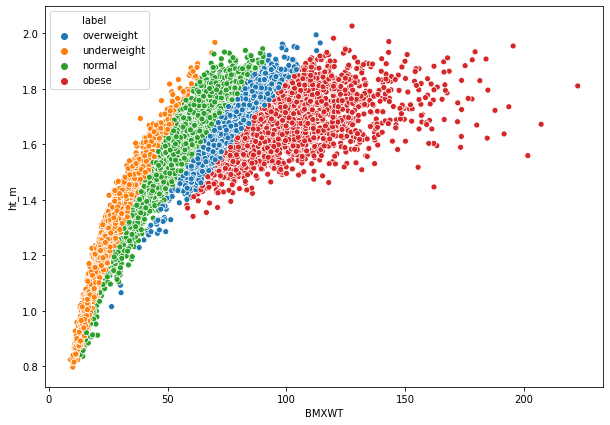

In [43]:
fig, ax = plt.subplots(1, figsize = (10, 7))
sns.scatterplot(x="BMXWT", y="ht_m", hue="label", data=df, ax= ax);

### Basketball players by position

In [46]:
df_nba = pd.read_excel('./data/nba_ht_wt.xls')
df_nba.head()

,Player,Pos,Height,Weight,Age,School,BDate
0,Vitor Faverani,C,83,260,25,None,1988-05-05
1,Avery Bradley,G,74,180,22,Texas,1990-11-26
2,Keith Bogans,G,77,215,33,Kentucky,1980-05-12
3,Jared Sullinger,F,81,260,21,Ohio State,1992-03-04
4,Jeff Green,F,81,235,27,Georgetown,1986-08-28


In [48]:
df_nba['weight_kg'] = df_nba['Weight'] * 0.45
df_nba['height_m'] = df_nba['Height']*0.025
df_nba['BMI'] = df_nba['weight_kg']/df_nba['height_m']**2
df_nba.head()

,Player,Pos,Height,Weight,Age,School,BDate,weight_kg,height_m,BMI
0,Vitor Faverani,C,83,260,25,None,1988-05-05,117.00,2.075,27.173755
1,Avery Bradley,G,74,180,22,Texas,1990-11-26,81.00,1.850,23.666910
2,Keith Bogans,G,77,215,33,Kentucky,1980-05-12,96.75,1.925,26.108956
3,Jared Sullinger,F,81,260,21,Ohio State,1992-03-04,117.00,2.025,28.532236
4,Jeff Green,F,81,235,27,Georgetown,1986-08-28,105.75,2.025,25.788752


In [49]:
df_nba['label'] = pd.cut(df_nba.BMI,
                     [-np.inf, 18.5, 25.0 , 30.0,np.inf],
                     labels=['underweight','normal', 'overweight','obese'])

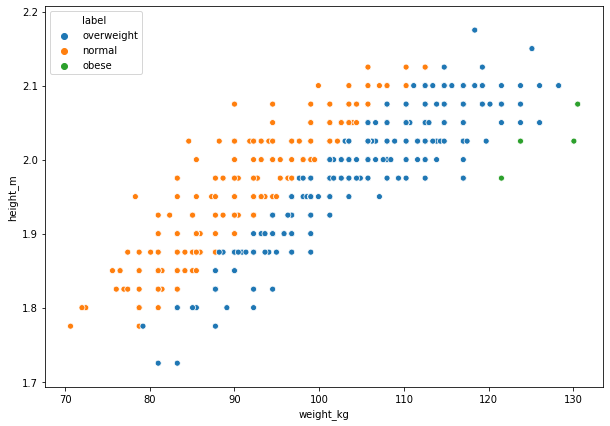

In [50]:
fig, ax = plt.subplots(1, figsize = (10, 7))
sns.scatterplot(x="weight_kg", y="height_m", hue="label", data=df_nba, ax= ax);

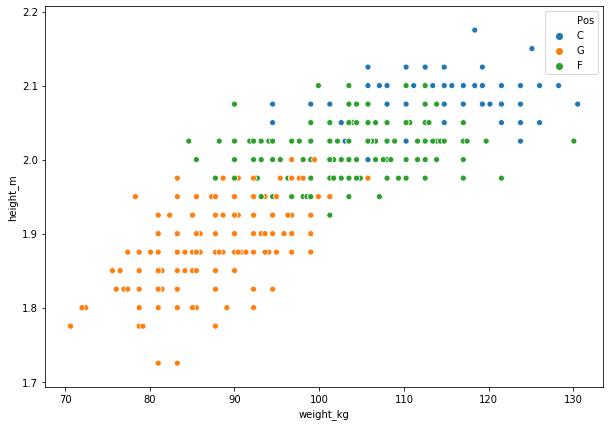

In [52]:
fig, ax = plt.subplots(1, figsize = (10, 7))
sns.scatterplot(x="weight_kg", y="height_m", hue="Pos",  data=df_nba, ax= ax);

## 2. スコアリング関数の開発

優れたスコアリング関数は、簡単に解釈できて、一般に信用できる、という点をもって評価される。性質をまとめると以下、

- 簡単に計算できる
- 簡単に理解できる
- 統計量の背後の考え方が説明しやすい
- 変数の解釈方法が単純なこと
- 外れ値に対してrobust
- 意味のある形で差をつける

### (1) Elo Rating Algorithm

- Elo Rating Algorithmはcompetitive gamesにおいてplayerをランク付けするときに用いられるアルゴリズム
- Elo Ratingが高いplayerほど強い
- FIFAランキングが一例

$$
r'(A) = r(A) + k(S_A - \mu_A)
$$

- $r'(A)$: updated後のplayer Aのスコア
- $r(A)$: updated前のplayer Aのスコア
- $k$: 試合の重要度
- $S_A$: 試合で獲得したスコア（例、勝ったら1, 負けたら-1）
- $\mu_A$: AがBと戦ったときの結果として予想された値

$$
\mu_A = 1\cdot P_{A>B} + (-1)\cdot (1 - P_{A>B})
$$

確率の計算にはロジットがナイーブに用いられる。

In [53]:
## ここにnested algorithm and simulation追加